In [2]:
import polars as pl
import tqdm
import numpy as np
import seaborn as sns

import sys
sys.path.append('/home/ubuntu/RecSysChallenge2024/src')

from fastauc.fastauc.fast_auc import fast_numba_auc

In [7]:
predictions_df = None

paths = {
    'gandalf': '/mnt/ebs_volume_new/stacking/pred_val_large/pred_val_gandalf_new_trial_130.parquet',
    'mlp': '/mnt/ebs_volume_new/stacking/pred_val_large/pred_val_mlp_new_trial_208.parquet',
    'wide_deep': '/mnt/ebs_volume_new/stacking/pred_val_large/pred_val_wide_deep_new_trial_72.parquet',
    'deep_cross': '/mnt/ebs_volume_new/stacking/pred_val_large/pred_val_deep_cross_new_trial_67.parquet',
    'catboost': '/mnt/ebs_volume_new/stacking/pred_val_large/pred_val_catboost_new_noK.parquet',
    'catboost_rnk': '/mnt/ebs_volume_new/stacking/pred_val_large/pred_val_cat_rnk_new_95.parquet',
    'catboost_rec': '/mnt/ebs_volume_new/stacking/pred_val_large/pred_val_catboost_classifier_recsys_tuned.parquet',
    # 'catboost_rnk_rec': '/mnt/ebs_volume_new/stacking/pred_val_large/',
    'lgbm': '/mnt/ebs_volume_new/stacking/pred_val_large/pred_val_lgbm_new_trial_289.parquet',
    'lgbm_rnk': '/mnt/ebs_volume_new/stacking/pred_val_large/pred_val_lgbm_ranker_new_trial_457.parquet',
    'lgbm_rec': '/mnt/ebs_volume_new/stacking/pred_val_large/pred_val_lgbm_recsys_trial_107.parquet',
    'lgbm_rnk_rec': '/mnt/ebs_volume_new/stacking/pred_val_large/pred_val_lgbm_ranker_recsys_trial_219.parquet',
}
for model_name, path in paths.items():
    
    model_preds = pl.read_parquet(path) \
        .rename({'prediction': f'{model_name}_prediction'}) \
        .with_columns(
            pl.col(f'{model_name}_prediction').min().over('impression_id').alias('min_pred_impression'),
            pl.col(f'{model_name}_prediction').max().over('impression_id').alias('max_pred_impression'),
        ).with_columns(
            (
                (pl.col(f'{model_name}_prediction') - pl.col('min_pred_impression')) /
                (pl.col('max_pred_impression') - pl.col('min_pred_impression'))
            ).alias(f'{model_name}_prediction')
        ).select(['impression_id', 'article', 'target', f'{model_name}_prediction'])
        
    evaluation_ds_grouped = model_preds.group_by(
            'impression_id').agg(pl.col('target'), pl.col(f'{model_name}_prediction'))
    
    # auc = np.mean(
    #     [fast_numba_auc(np.array(y_t).astype(bool), np.array(y_s).astype(np.float32)) 
    #         for y_t, y_s in zip(evaluation_ds_grouped['target'].to_list(), 
    #                             evaluation_ds_grouped[f'{model_name}_prediction'].to_list())]
    # )
    # print(f'AUC of {model_name}: {auc}')
    
    if predictions_df is None:
        predictions_df = model_preds
    else:
        predictions_df = predictions_df.join(model_preds.drop('target'), 
                                             on=['impression_id', 'article'], how='left')
predictions_df.head()

impression_id,article,target,gandalf_prediction,mlp_prediction,wide_deep_prediction,deep_cross_prediction,catboost_prediction,catboost_rnk_prediction,catboost_rec_prediction,lgbm_prediction,lgbm_rnk_prediction,lgbm_rec_prediction,lgbm_rnk_rec_prediction
u32,i32,i8,f32,f32,f32,f32,f64,f64,f64,f64,f64,f64,f64
420318,9778971,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4373833,9779748,0,0.570408,0.753856,0.684908,0.453153,0.580206,0.966413,0.483439,0.795848,0.980979,0.851892,0.999038
4373833,9779867,0,0.018086,0.090914,0.082379,0.057798,0.092913,0.537061,0.053269,0.10574,0.447422,0.108441,0.543009
4373833,9774789,0,0.099891,0.289521,0.116664,0.247316,0.137925,0.595251,0.068661,0.167448,0.440432,0.215711,0.570561
4368096,9780181,0,0.988786,0.92764,0.698794,0.858141,1.0,1.0,0.922772,0.920922,1.0,0.844765,1.0


<Axes: >

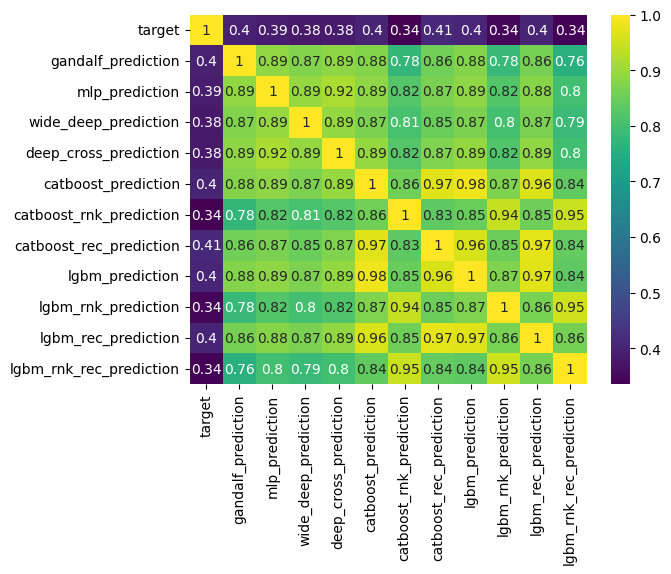

In [8]:
correlations = predictions_df.drop(['impression_id', 'article']).to_pandas().corr()

sns.heatmap(correlations, cmap='viridis', annot=True)

In [9]:
weight_mean_predictions_df = predictions_df.with_columns(
    (
        0.025 * pl.col('gandalf_prediction') + 
        0.025 * pl.col('mlp_prediction') + 
        0.025 * pl.col('wide_deep_prediction') + 
        0.025 * pl.col('deep_cross_prediction') +
        0.1 * pl.col('catboost_prediction') +
        0.15 * pl.col('catboost_rnk_prediction') +
        0.1 * pl.col('catboost_rec_prediction') +
        0.1 * pl.col('lgbm_prediction') +
        0.15 * pl.col('lgbm_rnk_prediction') +
        0.1 * pl.col('lgbm_rec_prediction') +
        0.2 * pl.col('lgbm_rnk_rec_prediction')
    ).alias('weight_mean_pred'),
)

evaluation_ds_grouped = weight_mean_predictions_df.group_by(
    'impression_id').agg(pl.col('target'), pl.col('weight_mean_pred'))

auc = np.mean(
    [fast_numba_auc(np.array(y_t).astype(bool), np.array(y_s).astype(np.float32)) 
        for y_t, y_s in zip(evaluation_ds_grouped['target'].to_list(), 
                            evaluation_ds_grouped['weight_mean_pred'].to_list())]
)
auc

0.8260198005118001

In [10]:
weight_mean_predictions_df = predictions_df.with_columns(
    (
        0.0125 * pl.col('gandalf_prediction') + 
        0.0125 * pl.col('mlp_prediction') + 
        0.0125 * pl.col('wide_deep_prediction') + 
        0.0125 * pl.col('deep_cross_prediction') +
        0.1 * pl.col('catboost_prediction') +
        0.15 * pl.col('catboost_rnk_prediction') +
        0.15 * pl.col('catboost_rec_prediction') +
        0.1 * pl.col('lgbm_prediction') +
        0.15 * pl.col('lgbm_rnk_prediction') +
        0.1 * pl.col('lgbm_rec_prediction') +
        0.2 * pl.col('lgbm_rnk_rec_prediction')
    ).alias('weight_mean_pred'),
)

evaluation_ds_grouped = weight_mean_predictions_df.group_by(
    'impression_id').agg(pl.col('target'), pl.col('weight_mean_pred'))

auc = np.mean(
    [fast_numba_auc(np.array(y_t).astype(bool), np.array(y_s).astype(np.float32)) 
        for y_t, y_s in zip(evaluation_ds_grouped['target'].to_list(), 
                            evaluation_ds_grouped['weight_mean_pred'].to_list())]
)
auc

0.8253677879711321

In [11]:
weight_mean_predictions_df = predictions_df.with_columns(
    (
        0.1 * pl.col('catboost_prediction') +
        0.15 * pl.col('catboost_rnk_prediction') +
        0.15 * pl.col('catboost_rec_prediction') +
        0.15 * pl.col('lgbm_prediction') +
        0.15 * pl.col('lgbm_rnk_prediction') +
        0.1 * pl.col('lgbm_rec_prediction') +
        0.2 * pl.col('lgbm_rnk_rec_prediction')
    ).alias('weight_mean_pred'),
)

evaluation_ds_grouped = weight_mean_predictions_df.group_by(
    'impression_id').agg(pl.col('target'), pl.col('weight_mean_pred'))

auc = np.mean(
    [fast_numba_auc(np.array(y_t).astype(bool), np.array(y_s).astype(np.float32)) 
        for y_t, y_s in zip(evaluation_ds_grouped['target'].to_list(), 
                            evaluation_ds_grouped['weight_mean_pred'].to_list())]
)
auc

0.8244524234282541

In [12]:
predictions_df = None

paths = {
    'gandalf': '/mnt/ebs_volume_new/stacking/pred_test/pred_test_gandalf_new_trial_130.parquet',
    'mlp': '/mnt/ebs_volume_new/stacking/pred_test/pred_test_mlp_new_trial_208.parquet',
    'wide_deep': '/mnt/ebs_volume_new/stacking/pred_test/pred_test_wide_deep_new_trial_72.parquet',
    'deep_cross': '/mnt/ebs_volume_new/stacking/pred_test/pred_test_deep_cross_new_trial_67.parquet',
    'catboost': '/mnt/ebs_volume_new/stacking/pred_test/pred_test_catboost_new_noK.parquet',
    'catboost_rnk': '/mnt/ebs_volume_new/stacking/pred_test/pred_test_cat_rnk_new_95.parquet',
    'catboost_rec': '/mnt/ebs_volume_new/stacking/pred_test/pred_test_catboost_classifier_recsys_tuned.parquet',
    # 'catboost_rnk_rec': '/mnt/ebs_volume_new/stacking/pred_test/',
    'lgbm': '/mnt/ebs_volume_new/stacking/pred_test/pred_test_lgbm_new_trial_289.parquet',
    'lgbm_rnk': '/mnt/ebs_volume_new/stacking/pred_test/pred_test_lgbm_ranker_new_trial_457.parquet',
    'lgbm_rec': '/mnt/ebs_volume_new/stacking/pred_test/pred_test_lgbm_recsys_trial_107.parquet',
    'lgbm_rnk_rec': '/mnt/ebs_volume_new/stacking/pred_test/pred_test_lgbm_ranker_recsys_trial_219.parquet',
}
for model_name, path in paths.items():
    
    model_preds = pl.read_parquet(path) \
        .rename({'prediction': f'{model_name}_prediction'}) \
        .with_columns(
            pl.col(f'{model_name}_prediction').min().over('impression_id').alias('min_pred_impression'),
            pl.col(f'{model_name}_prediction').max().over('impression_id').alias('max_pred_impression'),
        ).with_columns(
            (
                (pl.col(f'{model_name}_prediction') - pl.col('min_pred_impression')) /
                (pl.col('max_pred_impression') - pl.col('min_pred_impression'))
            ).alias(f'{model_name}_prediction')
        ).select(['impression_id', 'article', 'user_id', f'{model_name}_prediction'])
    
    if predictions_df is None:
        predictions_df = model_preds
    else:
        predictions_df = predictions_df.join(model_preds, on=['impression_id', 'article', 'user_id'], how='left')
predictions_df.head()

impression_id,article,user_id,gandalf_prediction,mlp_prediction,wide_deep_prediction,deep_cross_prediction,catboost_prediction,catboost_rnk_prediction,catboost_rec_prediction,lgbm_prediction,lgbm_rnk_prediction,lgbm_rec_prediction,lgbm_rnk_rec_prediction
u32,i32,u32,f32,f32,f32,f32,f64,f64,f64,f64,f64,f64,f64
6880427,9756075,1274780,0.077322,0.095132,0.232588,0.223017,0.327733,0.703275,0.236145,0.296036,0.650416,0.477471,0.682068
6869675,9789473,1238642,0.63036,0.804009,0.696939,0.806108,0.656307,0.917379,0.471971,0.625611,0.843805,0.595056,0.846462
6908287,9791205,1351925,0.71094,0.426831,0.63878,0.683612,0.100522,0.362297,0.138493,0.145939,0.255615,0.273622,0.401631
6871530,9791525,1245302,0.035608,0.004494,0.002756,0.034157,0.025607,0.382087,0.012795,0.019604,0.201146,0.00974,0.119817
6765726,9791515,1183377,0.648761,0.752831,0.966181,0.860698,0.624713,0.783561,0.500131,0.517039,0.739373,0.522909,0.748854


In [14]:
weight_mean_predictions_df = predictions_df.with_columns(
    (
        0.0125 * pl.col('gandalf_prediction') + 
        0.0125 * pl.col('mlp_prediction') + 
        0.0125 * pl.col('wide_deep_prediction') + 
        0.0125 * pl.col('deep_cross_prediction') +
        0.1 * pl.col('catboost_prediction') +
        0.15 * pl.col('catboost_rnk_prediction') +
        0.15 * pl.col('catboost_rec_prediction') +
        0.1 * pl.col('lgbm_prediction') +
        0.15 * pl.col('lgbm_rnk_prediction') +
        0.1 * pl.col('lgbm_rec_prediction') +
        0.2 * pl.col('lgbm_rnk_rec_prediction')
    ).alias('prediction'),
).select(['impression_id', 'article', 'user_id', 'prediction'])

weight_mean_predictions_df.write_parquet('/home/ubuntu/experiments/weighted_mean_predictions/predictions.parquet')